## INCOMES

**link to the data:**
https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

In [1]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.partitions import *
from utils.complete_missing_dates import *
from utils.df_transformations import *
from functools import reduce

# import necesary libraries
import os
import sys

#pyspark libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime
import pandas as pd
import numpy as np

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

## **Entity incomes**

In [2]:
# montly income
modelDataFile = "Data_ignore/ex1/df_income_g.csv"
df_income_g_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

modelDataFile = "Data_ignore/ex2/df_income_g.csv"
df_income_g_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

dfs = [df_income_g_1, df_income_g_2]
df_income_g = reduce(DataFrame.union, dfs)
df_income_g = (df_income_g.drop('_c0', 'g_country_id', 'gf_entity_id')
               .withColumn('account_seniority_y', col('account_seniority_m')/12).sort('gf_customer_id', 'monthly_partition'))

#complete empty months
df_income_g = (df_income_g.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition'))
.withColumn('monthly_partition', col('monthly_partition').cast('string')))
#df_income_g = (complete_missing_months(spark, df_income_g, 'monthly_partition', 'gf_customer_id'))
df_income_g_fill = df_income_g #.fillna(0)

#load outliers
modelDataFile = "Data_ignore/ex1/d_outliers_income.csv"
d_outliers_income_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

modelDataFile = "Data_ignore/ex2/d_outliers_income.csv"
d_outliers_income_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

dfs = [d_outliers_income_1, d_outliers_income_2]
d_outliers_income = reduce(DataFrame.union, dfs)
d_outliers_income = d_outliers_income.drop('_c0', 'g_country_id', 'gf_entity_id').sort('gf_customer_id', 'monthly_partition')
d_outliers_income = d_outliers_income.drop('_c0', 'g_country_id', 'gf_entity_id').sort('gf_customer_id', 'monthly_partition')

In [159]:
df_income_g.groupby('gf_customer_id').count().show()

+--------------+-----+
|gf_customer_id|count|
+--------------+-----+
|         45634|   15|
|            65|   17|
|           588|   17|
|           898|   11|
|          1621|   15|
|         48334|   15|
|         69933|   17|
|          1620|   15|
|      40195173|   15|
|          6726|   15|
|          1622|   15|
|         14138|   15|
|         43883|   16|
|      40649835|   17|
|          2086|   17|
+--------------+-----+



## Escalar

In [4]:
df_median = (df_income_g_fill.groupby('gf_customer_id').agg(mean('montly_amount').alias("mean")).select('gf_customer_id', 'mean'))
df_norm = (df_income_g_fill.join(df_median, 'gf_customer_id', 'left').withColumn('norm', col('montly_amount')- col('mean')).drop('mean'))
                                                             
d_outliers_norm = (find_outliers(df_norm.withColumn('year', year('monthly_partition')),
                           comparison_column = 'gf_customer_id', 
                           field_value = 'norm',
                          keep_columns = ['monthly_partition'],
                           only_outliers = False
                          )
              .withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")))
d_outliers_norm.drop('year').sort('gf_customer_id', 'monthly_partition').show(20, False)

number of outliers:  10
number of Normal values:  222
+--------------+---------+-----------------+----+---------+--------+---------+-------------+----------+----------+---------+-------------+---------------------+---------+
|gf_customer_id|norm     |monthly_partition|mean|median   |skewness|stddev   |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean        |Hotelling|
+--------------+---------+-----------------+----+---------+--------+---------+-------------+----------+----------+---------+-------------+---------------------+---------+
|65            |1465.828 |2019-11-30       |0.0 |-321.092 |1.697   |709.853  |0.0          |2129.56   |-2129.56  |false    |0.0          |1.061468959395952E16 |0.452    |
|65            |-337.322 |2019-12-31       |0.0 |-321.092 |1.697   |709.853  |0.0          |2129.56   |-2129.56  |false    |0.0          |1.061468959395952E16 |0.452    |
|65            |-337.322 |2020-01-31       |0.0 |-321.092 |1.697   |709.853  |0.0          

## log

In [8]:
df_income_g_fill = (df_income_g_fill.withColumn("log_montly_amount", sf.log(col("montly_amount"))))
d_outliers_log = find_outliers(df_income_g_fill.withColumn('year', year('monthly_partition')),
                           comparison_column = 'gf_customer_id', 
                           field_value =  'log_montly_amount', #'montly_amount',
                          keep_columns = ['monthly_partition', 'montly_amount'],
                          only_outliers = False, sigma = 1.5).sort('monthly_partition')
d_outliers_log = d_outliers_log.drop('year').sort('gf_customer_id', 'monthly_partition')
d_outliers_log = d_outliers_log.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))

TypeError: find_outliers() got an unexpected keyword argument 'sigma'

In [170]:
d_outliers_log.filter('''gf_customer_id = '69933' ''').drop('Hotelling', 'stddev_median').show(20, False)

+--------------+-----------------+-----------------+-------------+-----+------+--------+------+----------+----------+---------+-------------+-------------+
|gf_customer_id|log_montly_amount|monthly_partition|montly_amount|mean |median|skewness|stddev|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|
+--------------+-----------------+-----------------+-------------+-----+------+--------+------+----------+----------+---------+-------------+-------------+
|69933         |4.868            |2019-11-30       |130.0        |4.912|4.868 |1.755   |0.092 |5.05      |4.773     |false    |53.217       |0.019        |
|69933         |4.868            |2019-12-31       |130.0        |4.912|4.868 |1.755   |0.092 |5.05      |4.773     |false    |53.217       |0.019        |
|69933         |5.011            |2020-01-31       |150.0        |4.912|4.868 |1.755   |0.092 |5.05      |4.773     |false    |53.217       |0.019        |
|69933         |4.942            |2020-02-29       |140.0       

In [10]:
d_outliers.filter('''gf_customer_id = '43883' ''').show(20, False)

+--------------+-------------+-----------------+--------+-------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean    |median |skewness|stddev   |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+--------+-------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|43883         |3212.31      |2019-11-30       |8745.688|2977.09|3.608   |22756.284|0.0          |77014.539 |-59523.163|false    |0.384        |2.602        |0.253    |
|43883         |3703.79      |2020-01-31       |8745.688|2977.09|3.608   |22756.284|0.0          |77014.539 |-59523.163|false    |0.384        |2.602        |0.253    |
|43883         |2359.79      |2020-02-29       |8745.688|2977.09|3.608   |22756.284|0.0          |77014.539 |-59523.163|false    |0.384        |2.602      

In [3]:
d_outliers = (find_outliers(df_income_g_fill.withColumn('year', year('monthly_partition')),
                           comparison_column = 'gf_customer_id', 
                           field_value = 'montly_amount',
                          keep_columns = ['monthly_partition'],
                           only_outliers = False, lower_sigma = 3, upper_sigma  = 3
                          )
              .withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")))
d_outliers.drop('year').sort('gf_customer_id', 'monthly_partition').show(20, False)

number of outliers:  10
number of Normal values:  222
+--------------+-------------+-----------------+--------+-------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean    |median |skewness|stddev   |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+--------+-------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|65            |3606.3       |2019-11-30       |2140.472|1819.38|1.697   |709.853  |0.0          |4270.031  |10.912    |false    |3.015        |0.332        |0.452    |
|65            |1803.15      |2019-12-31       |2140.472|1819.38|1.697   |709.853  |0.0          |4270.031  |10.912    |false    |3.015        |0.332        |0.452    |
|65            |1803.15      |2020-01-31       |2140.472|1819.38|1.697   |709.853  |0.0          |427

In [5]:
d_outliers.filter(col('gf_customer_id').isin('6726')).drop('year').sort('gf_customer_id', 'monthly_partition').show(300, False)

+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean    |median |skewness|stddev  |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+
|6726          |5056.0       |2020-01-31       |7459.607|6493.18|2.225   |5147.895|0.0          |22903.293 |-7984.078 |false    |1.449        |0.69         |0.188    |
|6726          |4423.0       |2020-02-29       |7459.607|6493.18|2.225   |5147.895|0.0          |22903.293 |-7984.078 |false    |1.449        |0.69         |0.188    |
|6726          |8065.0       |2020-03-31       |7459.607|6493.18|2.225   |5147.895|0.0          |22903.293 |-7984.078 |false    |1.449        |0.69         |0.1

In [98]:
#true outliers
d_outliers = (find_outliers(df_income_g_fill.withColumn('year', year('monthly_partition')),
                           comparison_column = 'gf_customer_id', 
                           field_value = 'montly_amount',
                          keep_columns = ['monthly_partition'],
                           only_outliers = True
                          )
              .withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")))
d_outliers.drop('year').sort('gf_customer_id', 'monthly_partition').show(20, False)

number of outliers:  10
number of Normal values:  222
+--------------+-------------+-----------------+---------+--------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean     |median  |skewness|stddev   |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+---------+--------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|588           |61350.26     |2020-12-31       |6495.931 |1944.89 |3.561   |14374.539|-0.25        |49619.549 |-36627.686|true     |0.452        |2.213        |0.317    |
|1620          |10842.67     |2021-03-31       |3503.565 |3094.24 |2.546   |2215.832 |0.0          |10151.062 |-3143.932 |true     |1.581        |0.632        |0.185    |
|1621          |9842.67      |2021-03-31       |3854.229 |3242.22 |2.301   |1848.979 |1.0  

In [99]:
d_outliers.filter(col('gf_customer_id').isin('1622')).drop('year').sort('gf_customer_id', 'monthly_partition').show(300, False)

+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean    |median |skewness|stddev  |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+
|1622          |9842.67      |2021-03-31       |3854.229|3242.22|2.301   |1848.979|1.0          |9401.166  |-1692.708 |true     |2.085        |0.48         |0.331    |
+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+



In [100]:
d_outliers.filter(col('gf_customer_id').isin('1621')).drop('year').sort('gf_customer_id', 'monthly_partition').show(300, False)

+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean    |median |skewness|stddev  |stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+
|1621          |9842.67      |2021-03-31       |3854.229|3242.22|2.301   |1848.979|1.0          |9401.166  |-1692.708 |true     |2.085        |0.48         |0.331    |
+--------------+-------------+-----------------+--------+-------+--------+--------+-------------+----------+----------+---------+-------------+-------------+---------+



## **Plot series**

## Caso 1: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|          1622|       2020-01-31|      4590.27|2020|    1|              479.0| 39.916666666666664|
|          1622|       2020-02-29|      3094.24|2020|    2|              479.0| 39.916666666666664|
|          1622|       2020-03-31|      4190.27|2020|    3|              479.0| 39.916666666666664|
|          1622|       2020-04-30|      4055.62|2020|    4|              479.0| 39.916666666666664|
|          1622|       2020-05-31|      4015.59|2020|    5|              479.0| 39.916666666666664|
|          1622|       2020-06-30|      3135.49|2020|    6|              479.0| 39.916666666666664|
|          1622|       2020-07-31|      4511.59|2020|    7|              479.0| 39.916666666666664|


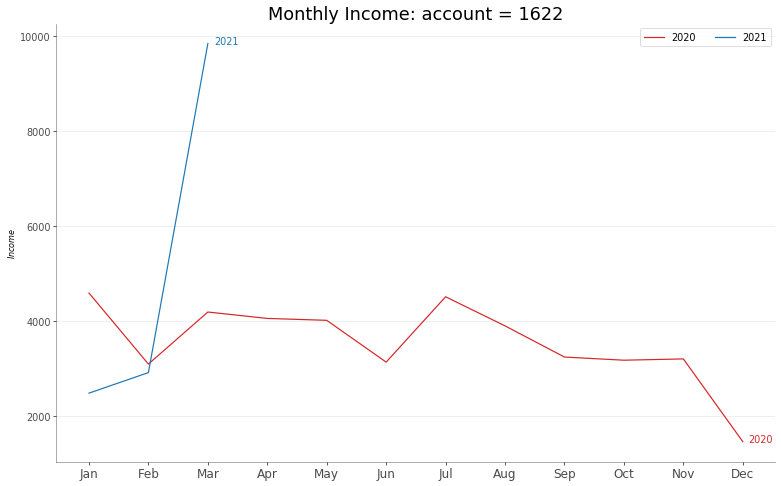

In [101]:
id_values = '1622'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|      40195173|       2020-01-31|      1719.92|2020|    1|               64.0|  5.333333333333333|
|      40195173|       2020-02-29|      2222.76|2020|    2|               64.0|  5.333333333333333|
|      40195173|       2020-03-31|      2406.16|2020|    3|               64.0|  5.333333333333333|
|      40195173|       2020-04-30|      2279.25|2020|    4|               64.0|  5.333333333333333|
|      40195173|       2020-05-31|      2316.77|2020|    5|               64.0|  5.333333333333333|
|      40195173|       2020-06-30|      2294.52|2020|    6|               64.0|  5.333333333333333|
|      40195173|       2020-07-31|      5672.97|2020|    7|               64.0|  5.333333333333333|


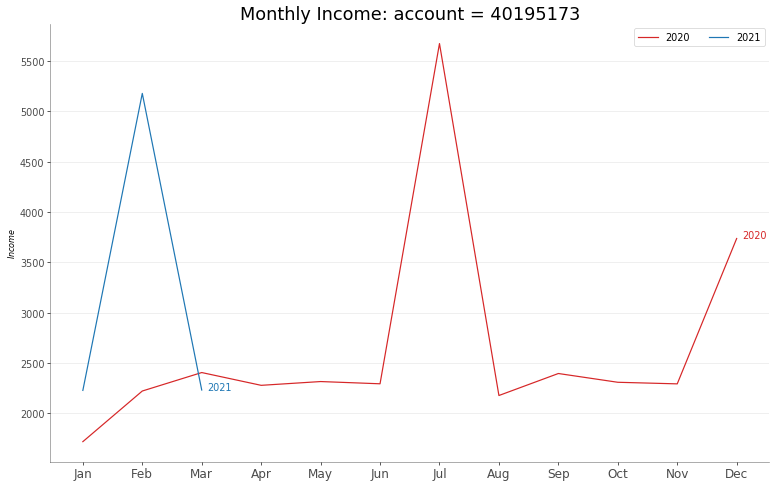

In [70]:
id_values = '40195173'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

In [72]:
id_values = '24919227'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+

+--------------+-------------+-----------------+----+------+--------+------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|mean|median|skewness|stddev|stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+----+------+--------+------+-------------+----------+----------+---------+-------------+-------------+---------+
+--------------+-------------+-----------------+----+------+--------+------+-------------+----------+----------+----

<Figure size 928x580 with 0 Axes>

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         14138|       2020-01-31|     12617.53|2020|    1|               null|               null|
|         14138|       2020-02-29|     12246.19|2020|    2|               null|               null|
|         14138|       2020-03-31|     12015.43|2020|    3|               null|               null|
|         14138|       2020-04-30|      9955.48|2020|    4|               null|               null|
|         14138|       2020-05-31|     16995.02|2020|    5|               null|               null|
|         14138|       2020-06-30|     13539.88|2020|    6|               null|               null|
|         14138|       2020-07-31|     12943.09|2020|    7|               null|               null|


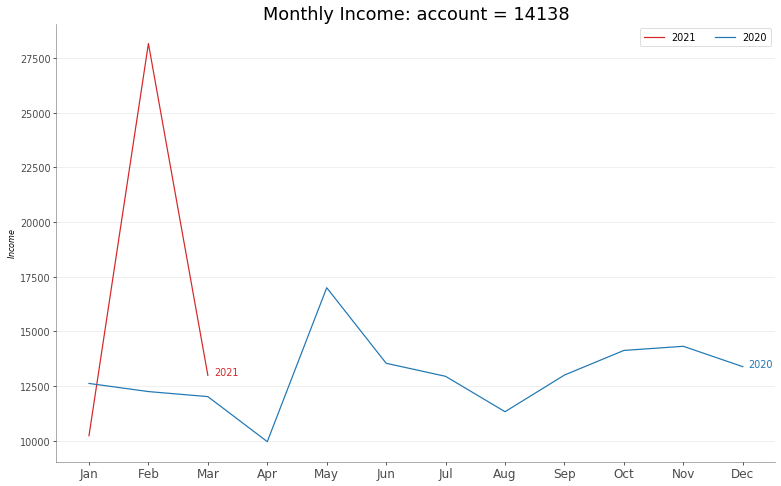

In [59]:
id_values = '14138'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|          1620|       2020-01-31|      1460.86|2020|    1|              479.0| 39.916666666666664|
|          1620|       2020-02-29|      3203.07|2020|    2|              479.0| 39.916666666666664|
|          1620|       2020-03-31|      3175.79|2020|    3|              479.0| 39.916666666666664|
|          1620|       2020-04-30|      3242.22|2020|    4|              479.0| 39.916666666666664|
|          1620|       2020-05-31|      1898.34|2020|    5|              479.0| 39.916666666666664|
|          1620|       2020-06-30|      4511.59|2020|    6|              479.0| 39.916666666666664|
|          1620|       2020-07-31|      2735.49|2020|    7|              479.0| 39.916666666666664|


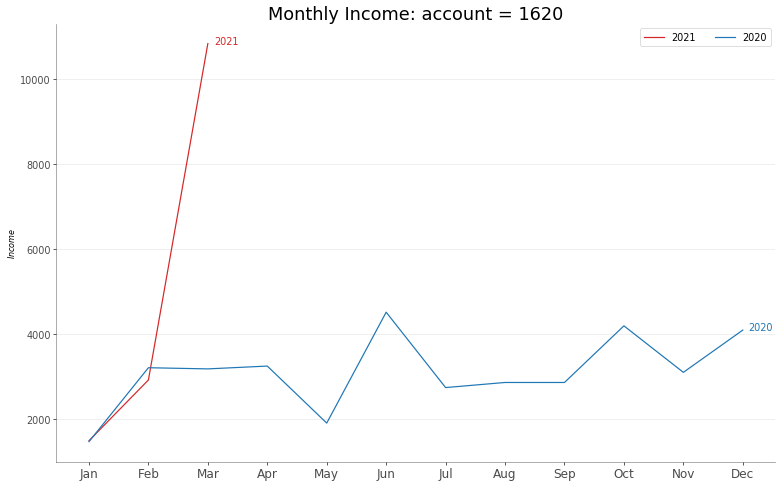

In [58]:
id_values = '1620'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|           898|       2020-01-31|       5600.0|2020|    1|               78.0|                6.5|
|           898|       2020-03-31|       5600.0|2020|    3|               78.0|                6.5|
|           898|       2020-06-30|      3441.82|2020|    6|               78.0|                6.5|
|           898|       2020-07-31|       5600.0|2020|    7|               78.0|                6.5|
|           898|       2020-08-31|       2800.0|2020|    8|               78.0|                6.5|
|           898|       2020-09-30|       8400.0|2020|    9|               78.0|                6.5|
|           898|       2020-10-31|       5600.0|2020|   10|               78.0|                6.5|


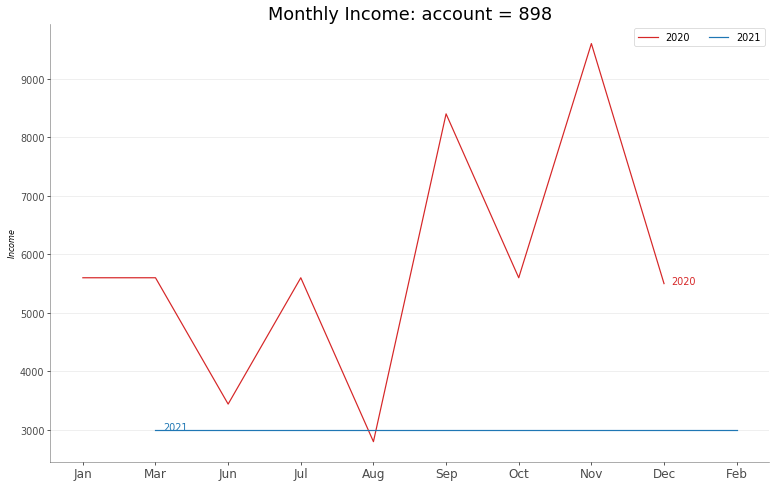

In [55]:
id_values = '898'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|           588|       2019-11-30|      4022.74|2019|   11|              115.0|  9.583333333333334|
|           588|       2019-12-31|      1919.67|2019|   12|              115.0|  9.583333333333334|
|           588|       2020-01-31|      1934.54|2020|    1|              115.0|  9.583333333333334|
|           588|       2020-02-29|      1933.96|2020|    2|              115.0|  9.583333333333334|
|           588|       2020-03-31|      1933.38|2020|    3|              115.0|  9.583333333333334|
|           588|       2020-04-30|       1640.9|2020|    4|              115.0|  9.583333333333334|
|           588|       2020-05-31|      2337.21|2020|    5|              115.0|  9.583333333333334|


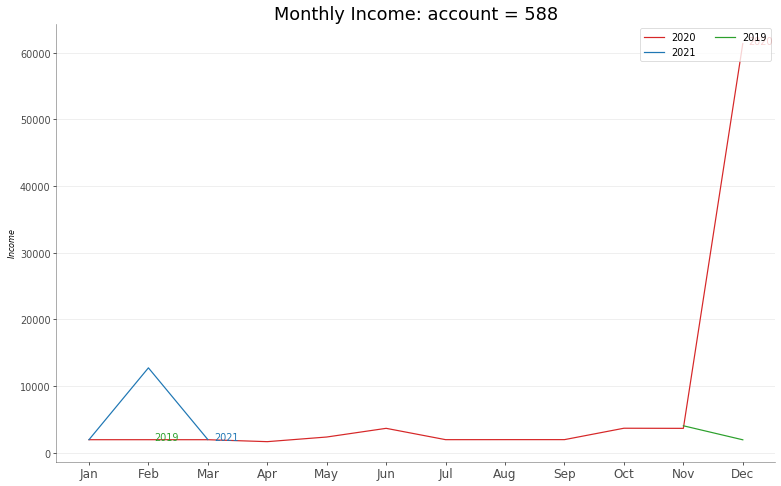

In [54]:
id_values = '588'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|            65|       2019-11-30|       3606.3|2019|   11|               66.0|                5.5|
|            65|       2019-12-31|      1803.15|2019|   12|               66.0|                5.5|
|            65|       2020-01-31|      1803.15|2020|    1|               66.0|                5.5|
|            65|       2020-02-29|      1819.38|2020|    2|               66.0|                5.5|
|            65|       2020-03-31|      1835.61|2020|    3|               66.0|                5.5|
|            65|       2020-04-30|      1819.38|2020|    4|               66.0|                5.5|
|            65|       2020-05-31|      1819.38|2020|    5|               66.0|                5.5|


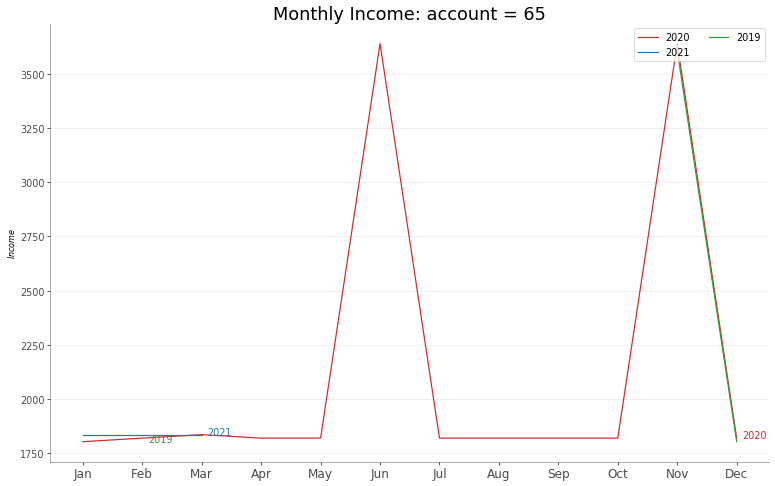

In [53]:
id_values = '65'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|          2086|       2019-11-30|      1769.24|2019|   11|               null|               null|
|          2086|       2019-12-31|      1059.62|2019|   12|               null|               null|
|          2086|       2020-01-31|      1059.62|2020|    1|               null|               null|
|          2086|       2020-02-29|      1066.01|2020|    2|               null|               null|
|          2086|       2020-03-31|       1072.4|2020|    3|               null|               null|
|          2086|       2020-04-30|       963.34|2020|    4|               null|               null|
|          2086|       2020-05-31|       716.01|2020|    5|               null|               null|


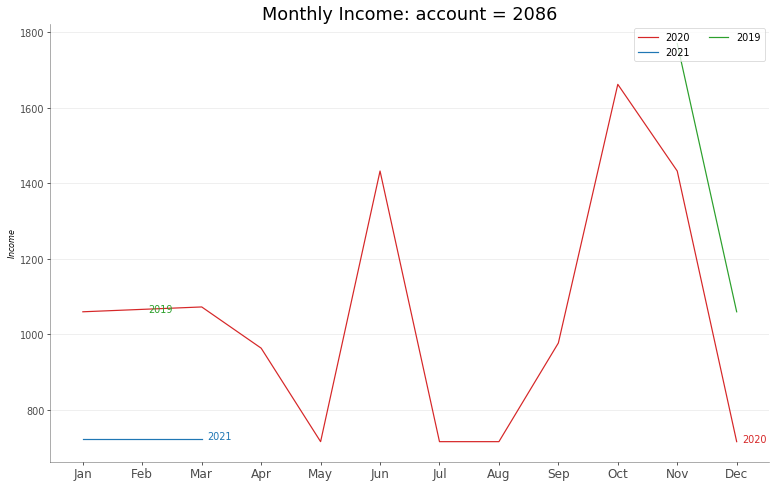

In [44]:
id_values = '2086'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

In [45]:
id_values = '1620'

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|          1620|       2020-01-31|      1460.86|2020|    1|              479.0| 39.916666666666664|
|          1620|       2020-02-29|      3203.07|2020|    2|              479.0| 39.916666666666664|
|          1620|       2020-03-31|      3175.79|2020|    3|              479.0| 39.916666666666664|
|          1620|       2020-04-30|      3242.22|2020|    4|              479.0| 39.916666666666664|
|          1620|       2020-05-31|      1898.34|2020|    5|              479.0| 39.916666666666664|
|          1620|       2020-06-30|      4511.59|2020|    6|              479.0| 39.916666666666664|
|          1620|       2020-07-31|      2735.49|2020|    7|              479.0| 39.916666666666664|


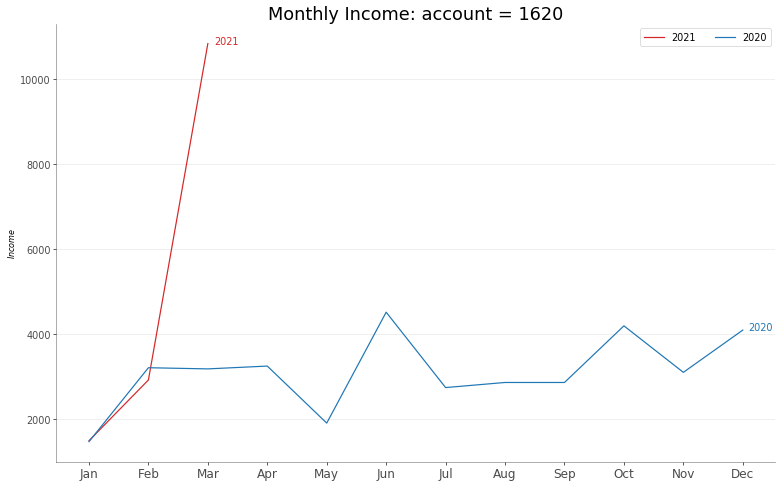

In [46]:
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()
#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Caso 2: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         45634|       2020-01-31|      1714.61|2020|    1|              195.0|              16.25|
|         45634|       2020-02-29|      1692.06|2020|    2|              195.0|              16.25|
|         45634|       2020-03-31|     18389.96|2020|    3|              195.0|              16.25|
|         45634|       2020-04-30|      1698.81|2020|    4|              195.0|              16.25|
|         45634|       2020-05-31|      1655.08|2020|    5|              195.0|              16.25|
|         45634|       2020-06-30|      3390.28|2020|    6|              195.0|              16.25|
|         45634|       2020-07-31|      1745.24|2020|    7|              195.0|              16.25|


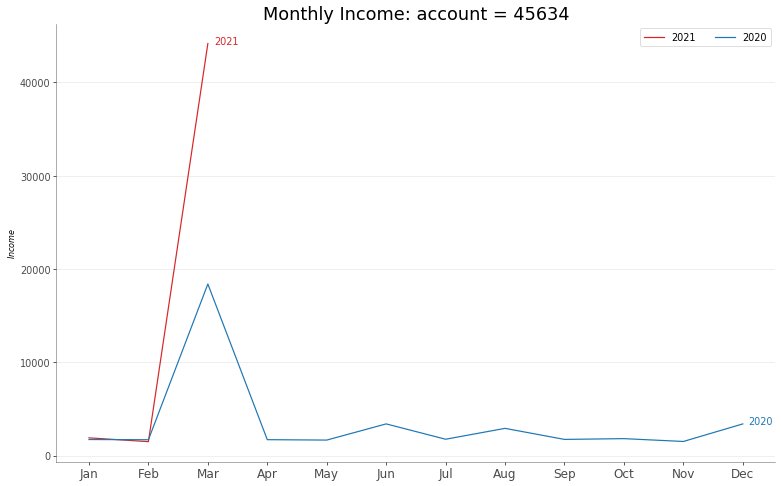

In [47]:
id_values = '45634'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Caso 3: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         69933|       2019-11-30|        130.0|2019|   11|               61.0|  5.083333333333333|
|         69933|       2019-12-31|        130.0|2019|   12|               61.0|  5.083333333333333|
|         69933|       2020-01-31|        150.0|2020|    1|               61.0|  5.083333333333333|
|         69933|       2020-02-29|        140.0|2020|    2|               61.0|  5.083333333333333|
|         69933|       2020-03-31|        140.0|2020|    3|               61.0|  5.083333333333333|
|         69933|       2020-04-30|        120.0|2020|    4|               61.0|  5.083333333333333|
|         69933|       2020-05-31|        130.0|2020|    5|               61.0|  5.083333333333333|


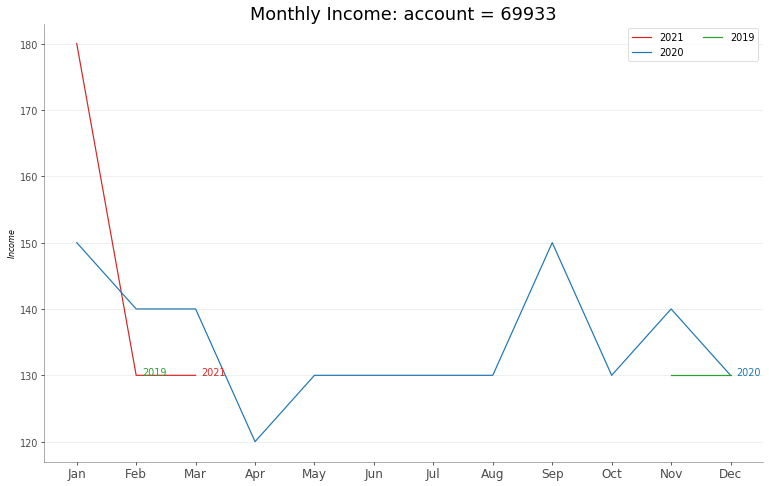

In [48]:
id_values = '69933'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## Caso 4: 

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|          6726|       2020-01-31|       5056.0|2020|    1|              233.0| 19.416666666666668|
|          6726|       2020-02-29|       4423.0|2020|    2|              233.0| 19.416666666666668|
|          6726|       2020-03-31|       8065.0|2020|    3|              233.0| 19.416666666666668|
|          6726|       2020-04-30|       3456.4|2020|    4|              233.0| 19.416666666666668|
|          6726|       2020-05-31|      2360.46|2020|    5|              233.0| 19.416666666666668|
|          6726|       2020-06-30|       3951.4|2020|    6|              233.0| 19.416666666666668|
|          6726|       2020-07-31|       9879.4|2020|    7|              233.0| 19.416666666666668|


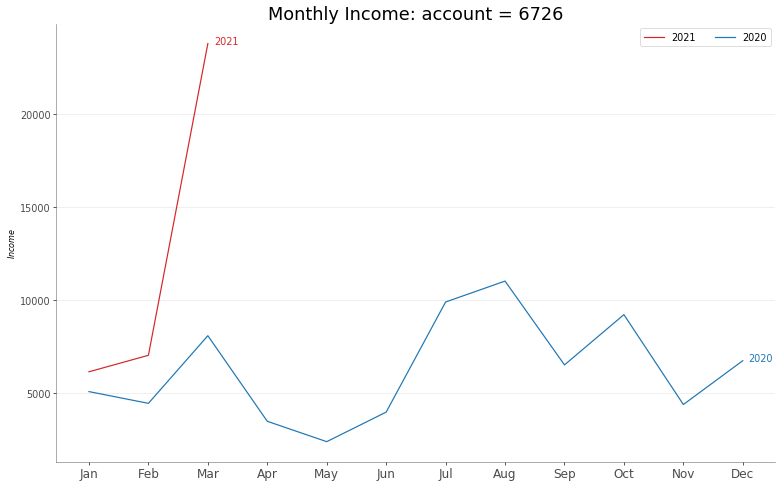

In [49]:
id_values = '6726'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         14138|       2020-01-31|     12617.53|2020|    1|               null|               null|
|         14138|       2020-02-29|     12246.19|2020|    2|               null|               null|
|         14138|       2020-03-31|     12015.43|2020|    3|               null|               null|
|         14138|       2020-04-30|      9955.48|2020|    4|               null|               null|
|         14138|       2020-05-31|     16995.02|2020|    5|               null|               null|
|         14138|       2020-06-30|     13539.88|2020|    6|               null|               null|
|         14138|       2020-07-31|     12943.09|2020|    7|               null|               null|


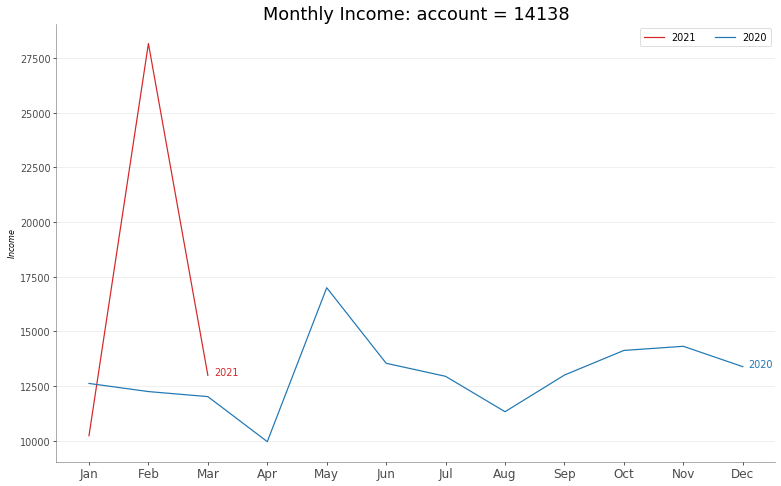

In [50]:
id_values = '14138'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         69933|       2019-11-30|        130.0|2019|   11|               61.0|  5.083333333333333|
|         69933|       2019-12-31|        130.0|2019|   12|               61.0|  5.083333333333333|
|         69933|       2020-01-31|        150.0|2020|    1|               61.0|  5.083333333333333|
|         69933|       2020-02-29|        140.0|2020|    2|               61.0|  5.083333333333333|
|         69933|       2020-03-31|        140.0|2020|    3|               61.0|  5.083333333333333|
|         69933|       2020-04-30|        120.0|2020|    4|               61.0|  5.083333333333333|
|         69933|       2020-05-31|        130.0|2020|    5|               61.0|  5.083333333333333|


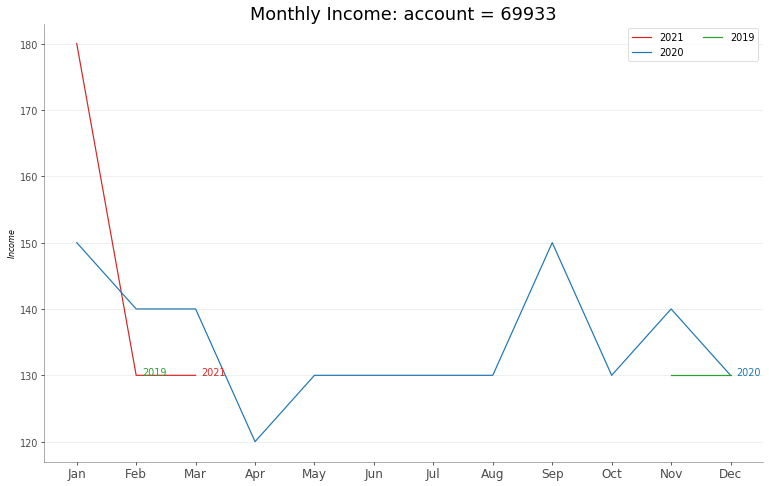

In [64]:
id_values = '69933'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+
|         43883|       2019-11-30|      3212.31|2019|   11|              172.0| 14.333333333333334|
|         43883|       2020-01-31|      3703.79|2020|    1|              172.0| 14.333333333333334|
|         43883|       2020-02-29|      2359.79|2020|    2|              172.0| 14.333333333333334|
|         43883|       2020-03-31|      2380.83|2020|    3|              172.0| 14.333333333333334|
|         43883|       2020-04-30|      3048.87|2020|    4|              172.0| 14.333333333333334|
|         43883|       2020-05-31|      2359.79|2020|    5|              172.0| 14.333333333333334|
|         43883|       2020-06-30|      4719.58|2020|    6|              172.0| 14.333333333333334|


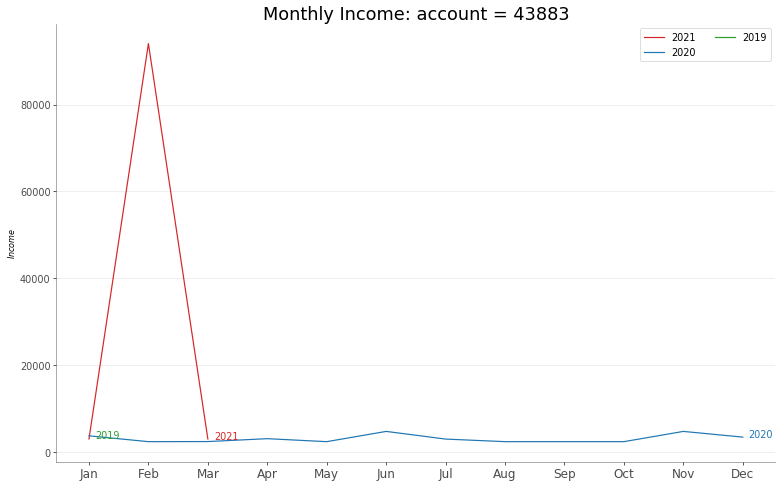

In [51]:
id_values = '43883'
df_income_g.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).sort('monthly_partition').show()
d_outliers.filter(col('gf_customer_id') == id_values).withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).show()

#transform data to pandas
df = (df_income_g.withColumn("monthly_partition", to_date('monthly_partition').cast("string"))
      .filter(col('gf_customer_id') == id_values).sort('month').toPandas())
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_amount'
plot_different_series(df, date_name, yaxis_field, title, ytitle)


## **Smoothing**

In [13]:
d_outliers.show()

+--------------+-------------+-----------------+---------+--------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|gf_customer_id|montly_amount|monthly_partition|     mean|  median|skewness|   stddev|stddev_median|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|Hotelling|
+--------------+-------------+-----------------+---------+--------+--------+---------+-------------+----------+----------+---------+-------------+-------------+---------+
|           588|     61350.26|       2020-12-31| 6495.931| 1944.89|   3.561|14374.539|        -0.25| 49619.549|-36627.686|     true|        0.452|        2.213|    0.317|
|          1620|     10842.67|       2021-03-31| 3503.565| 3094.24|   2.546| 2215.832|          0.0| 10151.062| -3143.932|     true|        1.581|        0.632|    0.185|
|          6726|      23793.0|       2021-03-31| 7459.607| 6493.18|   2.225| 5147.895|          0.0| 22903.293| -7984.078|     true|        1.449

In [9]:
d_outliers.printSchema()

root
 |-- gf_customer_id: integer (nullable = true)
 |-- montly_amount: double (nullable = true)
 |-- monthly_partition: string (nullable = true)
 |-- mean: double (nullable = true)
 |-- median: float (nullable = true)
 |-- skewness: double (nullable = true)
 |-- stddev: double (nullable = true)
 |-- stddev_median: float (nullable = true)
 |-- UpperLimit: double (nullable = true)
 |-- LowerLimit: double (nullable = true)
 |-- isOutlier: boolean (nullable = true)
 |-- ratio_mean_sd: double (nullable = true)
 |-- ratio_sd_mean: double (nullable = true)
 |-- Hotelling: double (nullable = true)



In [123]:
df_join = (df_income_g.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
           .join(d_outliers.select('gf_customer_id','monthly_partition', 'montly_amount', "isOutlier"), 
                            ['gf_customer_id','monthly_partition', 'montly_amount'], 'left')
          .withColumn('isOutlier', sf.when(col('isOutlier') ==True, 1).otherwise(0)) )
#df_join.filter(col('gf_customer_id') == id_values).show(20, False)

In [124]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import numpy as np 
from pyspark.sql.types import FloatType




def rolling_metric(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3):
    """
    Rolling Median & Mean 
    """
    
    median_udf = udf(lambda x: float(np.median(x)), FloatType())

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, -1)) #excluding the current month, only past values.
    df = df.select("*", (F.mean(value).over(w2)).alias("rolling_avg_" + str(window_size) + "m"))\
            #.filter(col('isOutlier')*col("rank")>=1)
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-(window_size - 1), 0))
    df = df.withColumn("list", collect_list(value).over(w2)) \
      .withColumn("rolling_median_" + str(window_size) + "m", median_udf("list").cast('double')).drop('date', 'rank') #'list', 
    
    return df

def rolling_metric_12m(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition"):
    """
    Rolling Mean of 12 months including the current one.
    """
    window_size = 12

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, 0)) #including the current month, only past values.
    df = (df.select("*", (F.mean(value).over(w2)).alias(value + "_avg_" + str(window_size) + "m"))
          .withColumn(value + "_avg_" + str(window_size) + "m",sf.when(col("rank")>=window_size, col(value + "_avg_" + str(window_size) + "m")).otherwise(0) ))
    
    return df

In [125]:
id_values = 1622

In [126]:
df_rolling = (rolling_metric(df_join, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition", window_size = 3))
(df_rolling.drop('mean', 'stddev', 'UpperLimit','LowerLimit').filter(col('gf_customer_id') == id_values).sort('monthly_partition').show(20, False))

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------------+---------------------------+-----------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|isOutlier|rolling_avg_3m    |list                       |rolling_median_3m|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------------+---------------------------+-----------------+
|1622          |2020-01-31       |4590.27      |2020|1    |479.0              |39.916666666666664 |0        |null              |[4590.27]                  |4590.27001953125 |
|1622          |2020-02-29       |3094.24      |2020|2    |479.0              |39.916666666666664 |0        |4590.27           |[4590.27, 3094.24]         |3842.2548828125  |
|1622          |2020-03-31       |4190.27      |2020|3    |479.0              |39.916666666666664 |0        |3842.255        

In [127]:
#sustitute 
df_rolling = (df_rolling.withColumn('inc_mean', sf.when(col('isOutlier')== 1, col('rolling_avg_3m')).otherwise(col('montly_amount')))
                        .withColumn('inc_median', sf.when(col('isOutlier')== 1, col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))
df_rolling.filter(col('gf_customer_id') == id_values).sort('monthly_partition').show(20, False)

+--------------+-----------------+-------------+---------+------------------+-----------------+
|gf_customer_id|monthly_partition|montly_amount|isOutlier|inc_mean          |inc_median       |
+--------------+-----------------+-------------+---------+------------------+-----------------+
|1622          |2020-01-31       |4590.27      |0        |4590.27           |4590.27          |
|1622          |2020-02-29       |3094.24      |0        |3094.24           |3094.24          |
|1622          |2020-03-31       |4190.27      |0        |4190.27           |4190.27          |
|1622          |2020-04-30       |4055.62      |0        |4055.62           |4055.62          |
|1622          |2020-05-31       |4015.59      |0        |4015.59           |4015.59          |
|1622          |2020-06-30       |3135.49      |0        |3135.49           |3135.49          |
|1622          |2020-07-31       |4511.59      |0        |4511.59           |4511.59          |
|1622          |2020-08-31       |3898.3

In [107]:
1050/3587.39

0.29269190135446665

In [130]:
df_comparison = rolling_metric_12m(df_rolling, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_median", date_field = "monthly_partition")
df_comparison.drop('UpperLimit', 'LowerLimit').filter(col('gf_customer_id') == id_values).sort('monthly_partition').show(2, False)

+--------------+-----------------+-------------+---------+--------+----------+----------+----+---------------------+----------------+------------------+
|gf_customer_id|monthly_partition|montly_amount|isOutlier|inc_mean|inc_median|date      |rank|montly_amount_avg_12m|inc_mean_avg_12m|inc_median_avg_12m|
+--------------+-----------------+-------------+---------+--------+----------+----------+----+---------------------+----------------+------------------+
|1622          |2020-01-31       |4590.27      |0        |4590.27 |4590.27   |2020-01-31|1   |0.0                  |0.0             |0.0               |
|1622          |2020-02-29       |3094.24      |0        |3094.24 |3094.24   |2020-02-29|2   |0.0                  |0.0             |0.0               |
+--------------+-----------------+-------------+---------+--------+----------+----------+----+---------------------+----------------+------------------+
only showing top 2 rows



In [156]:

month = '2021-03-31'
metric = "mean" #mean/ median
#d_outliers
att ="CF"# "DE" # ,  
#out
#n_counts, n_mean, n_sd


#verificar que termina el mes
def count_change(d_outliers, df_comparison, month, att, metric):
    if (att =="CF"):
        df_out = (d_outliers.filter(col('monthly_partition')== month).filter(col("isOutlier")== True)
                  .select("gf_customer_id", 'monthly_partition', metric, "isOutlier")
                  .join(df_comparison.filter(col('monthly_partition')== month).select("gf_customer_id", col("montly_amount_avg_12m").alias("original"),
                                                                                      col("inc_mean_avg_12m").alias("mean_aft"), col("inc_median_avg_12m").alias("median_aft")), 
                        "gf_customer_id", "inner"))
    else:
        df_out = (d_outliers.filter(col('monthly_partition')== month).filter(col("isOutlier")== True)
                  .select("gf_customer_id", 'monthly_partition', metric, "isOutlier")
                  .join(df_comparison.filter(col('monthly_partition')== month).select("gf_customer_id", col("montly_amount").alias("montly_amount"), 
                                                                                      col("inc_mean").alias("inc_mean"), col("inc_median").alias("inc_median")), 
                        "gf_customer_id", "inner"))
        #load debt_effort: debt -------------
        path = '/data/master/katt/data/_attributes/daily_debt_effort/partition_id=' + month + '/'
        df_debt = (spark.read.parquet(path).select('gf_customer_id', 'TD_INST_sum_amount_mov_0m')
                 .withColumn('TD_INST_sum_amount_mov_0m', (-1)*col('TD_INST_sum_amount_mov_0m')).filter('''TD_INST_sum_amount_mov_0m >0'''))
        #load debt_effort: debt
        debt_veriable = 'TD_INST_sum_amount_mov_0m'
        #--------------------------------------
        df_out = df_debt.select("gf_customer_id", col(debt_veriable).alias("debt")).join(df_out, "gf_customer_id", 'inner')
        df_out = (df_out.withColumn("original", col("debt")/col("montly_amount"))
                  .withColumn("mean_aft", col("debt")/col("inc_mean"))
                  .withColumn("median_aft", col("debt")/col("inc_median"))
                 )


    df = (df_out
                .withColumn("Int", sf.when(col(metric) <=0, "<0")
                            .when( (col(metric) >0) & (col(metric) <=10000),  "0-10000")
                            .when( (col(metric) >10000) & (col(metric) <=50000),  "10000.01-50000")
                            .when( (col(metric) >50000),  ">50000.01")
                            .otherwise('x'))
                .groupby('Int')
                .agg(sf.count(sf.lit(1)).alias('n_outliers'), sf.round(sf.mean("original"),2).alias('n_mean_bef'),  sf.round(stddev("original"),2).alias("stddev_bef"),
                     sf.round(sf.mean("mean_aft"),2).alias('n_mean_aft'),  sf.round(stddev("mean_aft"),2).alias("stddev_mean_aft"),
                     sf.round(sf.mean("median_aft"),2).alias('n_median_aft'),  sf.round(stddev("median_aft"),2).alias("stddev_median_aft")

                    )
                .withColumn('attribute', lit(att))
    )
    return df


df = count_change(d_outliers, df_comparison, month, att, metric)
df.show(5, False)

+-------+----------+----------+----------+----------+---------------+------------+-----------------+---------+
|Int    |n_outliers|n_mean_bef|stddev_bef|n_mean_aft|stddev_mean_aft|n_median_aft|stddev_median_aft|attribute|
+-------+----------+----------+----------+----------+---------------+------------+-----------------+---------+
|0-10000|5         |5220.86   |1901.63   |3972.02   |1457.05        |3977.12     |1468.97          |CF       |
+-------+----------+----------+----------+----------+---------------+------------+-----------------+---------+



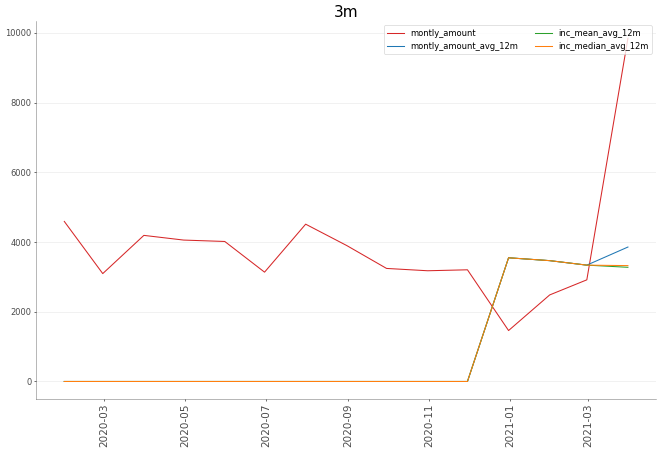

In [132]:
df = (to_explode(df_comparison.select('monthly_partition', 'gf_customer_id', 'montly_amount',  'montly_amount_avg_12m', 
                                      'inc_mean_avg_12m', 'inc_median_avg_12m'), ['monthly_partition', 'gf_customer_id']))
#Montly partition (end of the month): because we aggregate the transactions of the month
df = df.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
df = df.filter(col('gf_customer_id') == id_values) 
df = df.withColumn("monthly_partition", to_date('monthly_partition')).toPandas() #.cast("string")
plot_different_type_series(df, 'monthly_partition', 'movs', 'field',  title ='3m', ytitle = '', dpi_value = 50, width = 16, height = 10, text_ = False)

In [116]:
df_comparison.drop('UpperLimit', 'LowerLimit', 'inc_mean', 'inc_median').filter('''montly_amount_avg_12m > 0''').sort('gf_customer_id', 'monthly_partition').show(2000, False)

+--------------+-------------------+-------------+---------+----------+----+---------------------+------------------+------------------+
|gf_customer_id|monthly_partition  |montly_amount|isOutlier|date      |rank|montly_amount_avg_12m|inc_mean_avg_12m  |inc_median_avg_12m|
+--------------+-------------------+-------------+---------+----------+----+---------------------+------------------+------------------+
|1620          |2020-12-01 00:00:00|4090.27      |0        |2020-12-01|12  |3109.4483333333333   |3109.4483333333333|3109.4483333333333|
|1620          |2021-01-01 00:00:00|1482.28      |0        |2021-01-01|13  |2984.2815384615383   |2984.2815384615383|2984.2815384615383|
|1620          |2021-02-01 00:00:00|2915.14      |0        |2021-02-01|14  |3096.1492307692306   |3096.1492307692306|3096.1492307692306|
|1620          |2021-03-01 00:00:00|10842.67     |1        |2021-03-01|15  |3683.8107692307694   |3067.3923076923083|3074.000760967548 |
|6726          |2020-12-01 00:00:00|6720.

In [ ]:
#erase ...

## **Income**

- If we have a expense that is due to an increase in income ¿is it a pick?
- We can have the case of persons that does not have severla incomes, these are not equal. 

In [ ]:
df = to_explode(df_complet_year.select('monthly_partition', 'gf_customer_id', 'montly_expense', 'montly_income'), ['monthly_partition', 'gf_customer_id'])
df = df.filter(col('gf_customer_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('gf_customer_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='2m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

In [ ]:
import math 
df_complet_year_proy = (df_complet_year.select('gf_customer_id', 'montly_income', 'montly_expense')
 .withColumn('proyection', col('montly_expense')*math.cos(45)))

title = "Income vs expending"
x_label = 'Montly Expense' 
y_label = 'Montly Income'
x_field = 'montly_expense'
y_field = 'montly_income' 


df = df_complet_year.filter(col('gf_customer_id') == id_values).toPandas()
scatter_plot(df, x_field, y_field, title, x_label, y_label, dpi =40 )

In [ ]:
#transform data to pandas
df = df_complet_year.filter(col('gf_customer_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_income'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## **Change detection**

https://github.com/BMClab/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [ ]:
df_group.show(2, False)

In [ ]:
#just for now but we need to complete the data

df_group_2 = df_group.sort('account_id', 'monthly_partition').filter(col('account_id') == id_values)

In [ ]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
df_group_2 = df_group_2.withColumn('sum_amount_lag', lag('sum_amount').over(
            Window.partitionBy('account_id').orderBy('monthly_partition')))

In [ ]:
df_group_2.sort('account_id', 'monthly_partition').show(5, False)

In [ ]:
df_group_2 = df_group_2.withColumn('s_pos', col('sum_amount_lag') - col('sum_amount')).withColumn('cumsum', sf.sum('s_pos').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('s_neg', - col('sum_amount_lag') + col('sum_amount')).withColumn('cumsum', sf.sum('s_neg').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('g_neg', sf.when(col('s_neg')> 0, col('s_neg')).otherwise(0))
df_group_2 = df_group_2.withColumn('g_pos', sf.when(col('s_pos')> 0, col('s_pos')).otherwise(0))
df_group_2.show(20, False)                                                                                  

In [ ]:
df_g = df_group_2.toPandas()
plt.plot(df_g['monthly_partition'], df_g['g_neg'], c = 'b', label = 'g_neg')
plt.plot(df_g['monthly_partition'], df_g['g_pos'], c = 'r', label = 'g_pos')
#plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
#plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
#plt.plot(mean_minus_std, 'k--')
#plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()

## References
- [AN ADJUSTED BOXPLOT FOR SKEWED DISTRIBUTIONS](https://wis.kuleuven.be/stat/robust/papers/2004/boxplotCOMPSTAT04.pdf)
- [Top 50 matplotlib Visualizations](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/)
- Explaining Anomalies in Groups with Characterizing Subspace Rules(https://www.andrew.cmu.edu/user/lakoglu/pubs/18-pkdd-journal-xpacs.pdf)
- anomaly-detection-resources(https://github.com/yzhao062/anomaly-detection-resources#31-multivariate-data)
- https://github.com/BMClab/BMC

In [ ]:
#https://github.com/HamishWoodrow/anomaly_detection/blob/master/anom_detect.py
def plot(self,data_label=None,left=None,right=None,bottom=None,top=None):
        '''Anomalous datapoint plotting method
        This can be used to plot a visualisation of the data with the moving
        average, standard deviations and the anomalous data points marked.
        Parameters
        ----------
        data_label : str
            Raw data series name, to be displayed on y-axis and legend.
        left : int
            xlimit for left limit of plot x-axis
        right : int
            xlimit for right limit of plot x-axis
        bottom : int
            ylimit for bottom limit of plot y-axis
        top : int
            ylimit for top limit of plot y-axis
        '''
        df = self.results
        anoma_points = self.anoma_points
        fig, ax1 = plt.subplots(1, 1,figsize=(15, 8))
        ax1.plot(list(df.index),df.iloc[:,0],'b.',label=data_label)
        ax1.plot(list(df.index),df.mean_count,'r',label='Moving Average')
        ax1.fill_between(df.index,df.pos_std,df.neg_std,color='red',alpha=0.3,label='1Sigma')
        ax1.fill_between(df.index,df.pos_std_2,df.neg_std_2,color='red',alpha=0.1,label='2Sigma')
        ax1.plot(list(anoma_points.index),anoma_points.iloc[:,0],'r*',label='Anomalous Points')
        ax1.set_xlabel('time')
        ax1.set_ylabel(data_label)
        ax1.set_title('Data with Anomalies starred')
        ax1.set_xlim(left=left,right=right)
        ax1.set_ylim(bottom=bottom,top=top)
        ax1.legend();

In [ ]:
#Using Exponentially Weighted Moving Average for anomaly detection
#https://www.mikulskibartosz.name/using-exponentially-weighted-moving-average-for-anomaly-detection/

import pandas as pd
import matplotlib.pyplot as plt

window_size = 3
mean = work_days['Users'].ewm(window_size).mean()
std = work_days['Users'].ewm(window_size).std()
std[0] = 0 #the first value turns into NaN because of no data

mean_plus_std = mean + std
mean_minus_std = mean - std

is_outlier = (work_days['Users'] > mean_plus_std) | (work_days['Users'] < mean_minus_std)
outliers = work_days[is_outlier]

plt.plot(work_days['Users'], c = 'b', label = 'Actual Values')
plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
plt.plot(mean_minus_std, 'k--')
plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()

In [109]:
42267.70+2256+6409.85

50933.549999999996

In [ ]:
#Weighted moving average in Pyspark
#https://stackoverflow.com/questions/47622447/weighted-moving-average-in-pyspark
from pyspark.sql.functions import coalesce, lit, col, lead, lag
from operator import add
from functools import reduce

def weighted_average(c, window, offsets, weights):
    assert len(weights) == len(offsets)

    def value(i):
        if i < 0: return lag(c, -i).over(window)
        if i > 0: return lead(c, i).over(window)
        return c

    # Create a list of Columns
    # - `value_i * weight_i` if `value_i IS NOT NULL` 
    # - literal 0 otherwise
    values = [coalesce(value(i) * w, lit(0)) for i, w in zip(offsets, weights)]

    # or sum(values, lit(0))
    return reduce(add, values, lit(0))


from pyspark.sql.window import Window

df = spark.createDataFrame([
    ("a", 1, 1.4), ("a", 2, 8.0), ("a", 3, -1.0), ("a", 4, 2.4),
    ("a", 5, 99.0), ("a", 6, 3.0), ("a", 7, -1.0), ("a", 8, 0.0)
]).toDF("id", "time", "value")

w = Window.partitionBy("id").orderBy("time")
offsets, delays =  [-2, -1, 0, 1, 2], [0.1, 0.20, 0.4, 0.20, 0.1]

result = df.withColumn("avg", weighted_average(
    col("value"), w, offsets, delays
))
result.show()


In [ ]:
#The Exponential Moving Average (EMA), the Exponential Moving Standard Deviation (EDS)
#https://machinelearnings.co/data-science-tricks-simple-anomaly-detection-for-metrics-with-a-weekly-pattern-2e236970d77#.cij9voloi
##https://stackoverflow.com/questions/33959294/apache-spark-exponential-moving-average   
    
my_window = Window.orderBy("timestamp")

df.withColumn("price_lag_1",when(lag(col("price"),1).over(my_window).isNull,lit(0)).otherwise(lag(col("price"),1).over(my_window)))

df.withColumn("ema_price", 
price * lit(0.4) * Math.pow(0.6,0) + 
lag(col("price"),1).over(my_window) * 0.4 * Math.pow(0.6,1) +
lag(col("price"),2).over(my_window) * 0.4 * Math.pow(0.6,2)  + .... )

def emaFunc (y: org.apache.spark.sql.Column, group: org.apache.spark.sql.Column, order: org.apache.spark.sql.Column, beta: Double, lookBack: Int) : org.apache.spark.sql.Column = {
  val ema_window = Window.partitionBy(group).orderBy(order)
  var i = 1
  var result = y
  while (i < lookBack){
    result =  result + lit(1) * ( when(lag(y,i).over(ema_window).isNull,lit(0)).otherwise(lag(y,i).over(ema_window)) * beta * Math.pow((1-beta),i) 
    - when(lag(y,i).over(ema_window).isNull,lit(0)).otherwise(y * beta * Math.pow((1-beta),i))   )
    i = i + 1
  }
  return result } 

df.withColumn("one",lit(1))
  .withColumn("ema_price", emaFunc('price,'one,'timestamp,0.1,10)
                                   


In [ ]:
Holt-Winter ETS
https://medium.com/@tle3006/single-seasonal-time-series-anomaly-detection-with-brutlags-algorithm-and-holt-winter-ets-d8aea1fd1bfc

https://datascience.aero/anomaly-detection/
- Change detectors based on z-scores: Z-Score measures the distance from the population mean in units of the standard error. It can be used to identify when a sample is deviating from the expected statistic of the population. One common approach is to maintain two sets of statistics (e.g. mean and std) that describe the signal and compare them using z-score.
- Cumulative sum control chart (CUSUM): It iteratively calculates the weighted cumulative sum. When this sum exceeds a certain threshold value, a change value has been found. It is a valuable “online” methodology with plenty of use in streaming change detection. There are plenty of available implementations of this algorithm.
- Bayesian detection: This method is based on the prior train of thought on how probable is it to have two successive change-points with certain distance. Then, it models the likelihood of the data in the sequence given that there is no change-point in the sequence. This methodology works well but can be slow depending on the length of the time series. There are plenty of implementations in both Python and R.
- Cost sensitive methods

- (Instance-Dependent Cost-Sensitive Learning for Detecting Transfer Fraud)[https://arxiv.org/abs/2005.02488#:~:text=Instance%2DDependent%20Cost%2DSensitive%20Learning%20for%20Detecting%20Transfer%20Fraud,-Sebastiaan%20H%C3%B6ppner%2C%20Bart&text=Fraud%20detection%20is%20to%20be,for%20learning%20a%20classification%20model.]

# Cluster Identication Using Projections

Code of the paper: 

Peña, D., & Prieto, F. J. (2011). Cluster identification using projections. Journal of the American Statistical Association.

#Link:
http://halweb.uc3m.es/esp/Personal/personas/dpena/publications/ingles/2001JASA_prieto.pdf

Mirroring from: http://halweb.uc3m.es/fjp/download.html

https://e-archivo.uc3m.es/bitstream/handle/10016/15524/cluster_prieto_JASA_2001_ps.pdf?sequence=1

In [ ]:
# proy 
https://www.dropbox.com/s/jkpg18n6xnwcie2/proy.txt?dl=0

In [ ]:

https://datascienceplus.com/robust-regressions-dealing-with-outliers-in-r/
https://anomaly.io/anomaly-detection-normal-distribution/
https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

 


Code in R to check outliers

%%R -i xx -w 500 -h 400 -u px
dt = as.data.frame(xx)
names(dt) <- c('importe')
#outlierKD(dt, 'importe') 
var = 'importe'
#
var_name <- dt$importe #eval(substitute(var),eval(dt))

# own functions 

na1 <- sum(is.na(var_name))
m1 <- mean(var_name, na.rm = T)
par(mfrow=c(2, 3), oma=c(0,0,3,0))
boxplot(var_name, main="With outliers")
hist(var_name, main="With outliers", xlab=NA, ylab=NA)
outlier <- boxplot.stats(var_name)$out
mo <- mean(outlier)
qqnorm(var_name)
qqline(var_name)

var_name <- ifelse(var_name %in% outlier, NA, var_name)
boxplot(var_name, main="Without outliers")
hist(var_name, main="Without outliers", xlab=NA, ylab=NA)
title("Outlier Check", outer=TRUE)
na2 <- sum(is.na(var_name))
cat("Outliers identified:", na2 - na1, "\n")
cat("Propotion (%) of outliers:", round((na2 - na1) / sum(!is.na(var_name))*100, 1), "n")
cat("Mean of the outliers:", round(mo, 2), "\n")
m2 <- mean(var_name, na.rm = T)
cat("Mean without removing outliers:", round(m1, 2), "\n")
cat("Mean if we remove outliers:", round(m2, 2), "\n")

qqnorm(var_name)
qqline(var_name)

    